In [1]:
# !pip install snowflake --user
# !pip install snowflake-connector-python --user
# !pip install matplotlib
# !pip install seaborn

# Data

In [2]:
import os
import sys
path=!pwd
sys.path.append(os.path.join(path[0], '..'))
from utils import *
import snowflake.connector

In [3]:
pd.set_option('display.max_rows', 1000)

In [4]:
class SnowflakeConnector(BaseConnector):
    def __init__(self, credentials: Credentials):
        keys = credentials.get_keys()
        self._secrets = json.loads(keys.get('SecretString', "{}"))

    def connect(self, dbname: str, schema: str = 'DEFAULT'):
        ctx = snowflake.connector.connect(
            user=self._secrets['login_name'],
            password=self._secrets['login_password'],
            account=self._secrets['account'],
            warehouse=self._secrets['warehouse'],
            database=dbname,
            schema=schema
        )

        return ctx
    
## Credentials
SF_CREDS = 'datascience-max-dev-sagemaker-notebooks'

## Snowflake connection 
conn=SnowflakeConnector(SSMPSCredentials(SF_CREDS))
ctx=conn.connect("MAX_PROD","DATASCIENCE_STAGE")

In [5]:
def run_query(query):
    cursor = ctx.cursor()
    cursor.execute(query)
    df = pd.DataFrame(cursor.fetchall(), columns = [desc[0] for desc in cursor.description])
    df.columns= df.columns.str.lower()
    return df

In [6]:
meta_data = run_query('''
SELECT DISTINCT title_name,  match_id, season_number, content_category, single_episode_ind, 
                platform_name, earliest_offered_timestamp, last_offered_timestamp, earliest_public_timestamp 
                
FROM max_prod.workspace.title_retail_funnel_metrics
''')

# Total Viewing Accounts

In [7]:
from matplotlib.pyplot import figure

In [8]:
# daily_total_views = run_query('''
# SELECT 
#     a.request_date,
#     count(distinct hbo_uuid) as total_viewing_accounts
# from max_prod.viewership.max_user_stream_heartbeat a
#  left join max_prod.catalog.reporting_asset_dim b on a.viewable_id=b.viewable_id
#  left join max_prod.core.geo_map c on a.country_iso_code=c.country_iso_code
#  left join max_prod.catalog.reporting_asset_offering_dim d on a.viewable_id=d.viewable_id and brand='HBO MAX' and c.territory=d.territory and d.channel='HBO MAX SUBSCRIPTION'
# where a.stream_elapsed_play_seconds>=120
#  and first_offered_date<=a.request_time_gmt
#  and region='NORTH AMERICA'
#  and asset_type='FEATURE'
#  and video_type='main'
# group by 1
# order by 1
# ''')

In [ ]:
# daily_total_views.to_csv('daily_total_views.csv')

In [17]:
daily_total_views = pd.read_csv('daily_total_views.csv')

In [46]:
daily_total_views[(daily_total_views['request_date'] >= '2021-05-01')
                 &(daily_total_views['request_date'] <= '2021-06-01')]

,Unnamed: 0,request_date,total_viewing_accounts
278,278,2021-03-01,5403460
279,279,2021-03-02,5062362
280,280,2021-03-03,4794404
281,281,2021-03-04,4677751
282,282,2021-03-05,4615980
283,283,2021-03-06,5086051
284,284,2021-03-07,5341300
285,285,2021-03-08,4936199
286,286,2021-03-09,4734759
287,287,2021-03-10,4618893


In [51]:
plot_df = daily_total_views[daily_total_views['Unnamed: 0'].mod(1) == 0]

In [53]:
plot_df['request_date'] = pd.to_datetime(plot_df['request_date'], format='%Y-%m-%d')

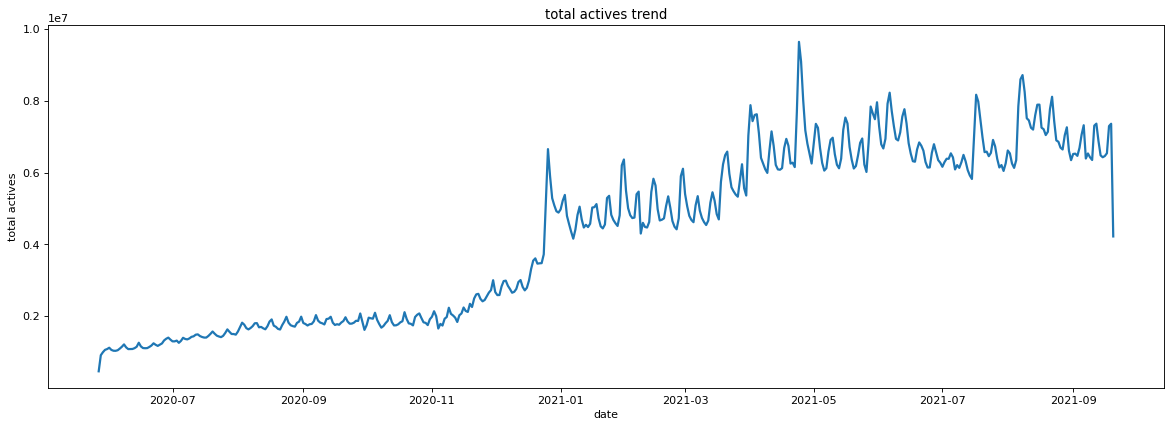

In [54]:
figure(figsize=(18, 6), dpi=80)
plot = plt.plot(plot_df['request_date'], plot_df['total_viewing_accounts'],
                linewidth=2)
plt.title('total actives trend')
plt.xlabel('date')
plt.ylabel('total actives')
print (plot)

In [44]:
## The sudden increase was at Dec 24, 2020 - DUE TO roll out Rocu, amazon, and the wonder women
## The peak is happening on Sundays/Mondays (episode releases?)

### Totoal Actives 28 days

In [18]:
daily_total_views_28 = run_query('''
select *  from max_dev.workspace.activse_base_28days
where datediff(day, start_date, end_date) = 28
order by start_date
''')

In [19]:
plot_df = daily_total_views_28
plot_df['start_date'] = pd.to_datetime(plot_df['start_date'], format='%Y-%m-%d')

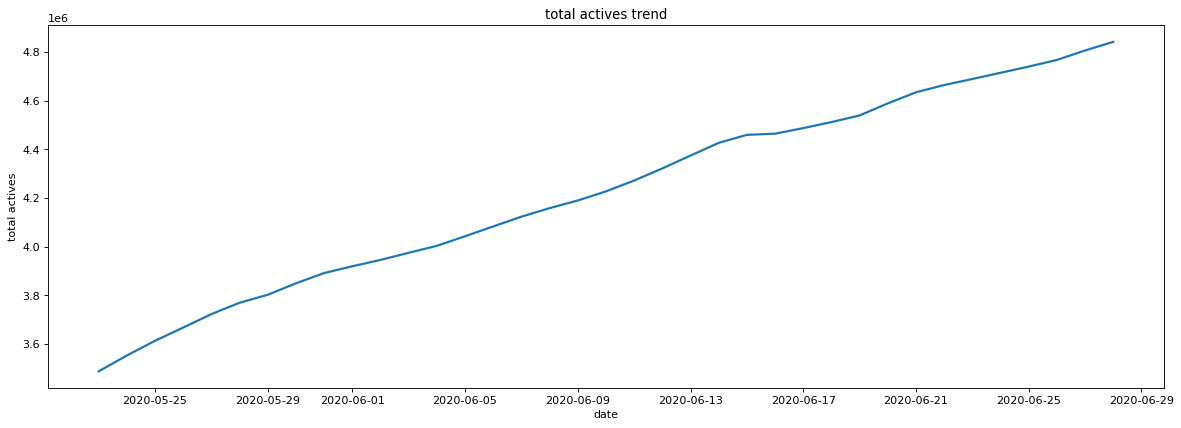

In [21]:
figure(figsize=(18, 6), dpi=80)
plot = plt.plot(plot_df['start_date'], plot_df['total_viewing_accounts'],
                linewidth=2)
plt.title('total actives trend')
plt.xlabel('date')
plt.ylabel('total actives')
print (plot)

# By title Viewing Accounts

In [24]:
title_actives = run_query('''
select *  from max_dev.workspace.ds_content_actives
''')

In [28]:
title_actives[title_actives['match_id'] == 'GXnzXWA8PcFSpjQEAAATH-1']

,title_name,season_number_adj,match_id,available_date,real_date,days_after_launch,total_viewing_accounts,total_plays,stream_elapsed_play_seconds
0,Doctor Who,1.0,GXnzXWA8PcFSpjQEAAATH-1,2020-05-27 07:00:00.000,2020-06-16,20,118097,1847905,3.999393e+09
2242,Doctor Who,1.0,GXnzXWA8PcFSpjQEAAATH-1,2020-05-27 07:00:00.000,2020-06-12,16,109601,1516986,3.267663e+09
5125,Doctor Who,1.0,GXnzXWA8PcFSpjQEAAATH-1,2020-05-27 07:00:00.000,2020-06-13,17,111758,1597757,3.446232e+09
7754,Doctor Who,1.0,GXnzXWA8PcFSpjQEAAATH-1,2020-05-27 07:00:00.000,2020-06-14,18,113933,1683509,3.638164e+09
10080,Doctor Who,1.0,GXnzXWA8PcFSpjQEAAATH-1,2020-05-27 07:00:00.000,2020-06-15,19,116030,1766536,3.821022e+09
14845,Doctor Who,1.0,GXnzXWA8PcFSpjQEAAATH-1,2020-05-27 07:00:00.000,2020-06-08,12,97469,1157377,2.489775e+09
16651,Doctor Who,1.0,GXnzXWA8PcFSpjQEAAATH-1,2020-05-27 07:00:00.000,2020-06-04,8,78488,771724,1.646096e+09
20284,Doctor Who,1.0,GXnzXWA8PcFSpjQEAAATH-1,2020-05-27 07:00:00.000,2020-05-31,4,56717,399606,8.440597e+08
26158,Doctor Who,1.0,GXnzXWA8PcFSpjQEAAATH-1,2020-05-27 07:00:00.000,2020-05-27,0,12120,33713,6.569025e+07
26896,Doctor Who,1.0,GXnzXWA8PcFSpjQEAAATH-1,2020-05-27 07:00:00.000,2020-05-28,1,28169,118560,2.414795e+08


# % Actives


In [ ]:
pct_actives = 